In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from wavepack.wavelet_packet import *
import torch
import numpy as np
import itertools
import nibabel as nib
from pathlib import Path

In [3]:
device = torch.device("cuda:10")

In [4]:
lo, hi, lo_rec, hi_rec = get_wavelet_filters('haar', device=device)

In [5]:
levels = 4

In [9]:
x = nib.load("/ISFILE3/USERS/remediossw/data/OASIS3/orig/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz").get_fdata(dtype=np.float32)
x = np.pad(x, ((256-176, 0), (0, 0), (0, 0)))
x = torch.from_numpy(x).unsqueeze(0).unsqueeze(1).to(device)

In [20]:
w = fwpt(x, lo, hi, levels)

In [21]:
x_hat = ifwpt(w, lo_rec, hi_rec, levels)

In [22]:
x_hat.shape

torch.Size([1, 1, 256, 256, 256])

In [23]:
x.shape

torch.Size([1, 1, 256, 256, 256])

In [24]:
(x - x_hat).abs().max()

tensor(0.0005, device='cuda:10')

In [119]:
w = F.conv3d(x, k_dec, stride=2**levels)

In [120]:
w.shape

torch.Size([1, 4096, 16, 16, 16])

In [121]:
x_hat = F.conv_transpose3d(w, k_rec, stride=2**levels)

In [122]:
x_hat.shape

torch.Size([1, 1, 256, 256, 256])

In [123]:
import matplotlib.pyplot as plt

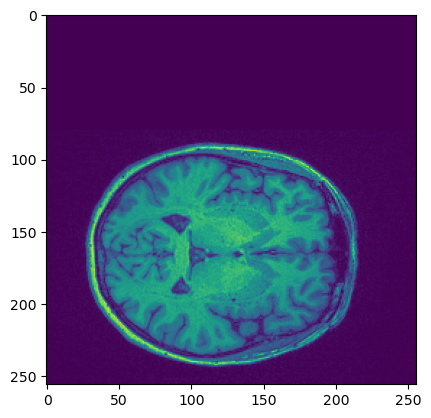

In [126]:
plt.imshow(x_hat.squeeze().detach().cpu().numpy()[:,:, 128])

In [16]:
k_rec.shape

torch.Size([512, 1, 8, 8, 8])

In [19]:
(k_dec == k_rec).all()

tensor(True, device='cuda:10')

In [10]:
# todo: upsampling, then test if strided convolution works

In [50]:
K_2d = build_2d_wavelet_packet_kernel(lo, hi, levels=2)
print(K_2d.shape)

torch.Size([16, 1, 4, 4])


In [51]:
K_2d

tensor([[[[ 0.2500,  0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.2500,  0.2500]]],


        [[[-0.2500, -0.2500,  0.2500,  0.2500],
          [-0.2500, -0.2500,  0.2500,  0.2500],
          [-0.2500, -0.2500,  0.2500,  0.2500],
          [-0.2500, -0.2500,  0.2500,  0.2500]]],


        [[[ 0.2500, -0.2500,  0.2500, -0.2500],
          [ 0.2500, -0.2500,  0.2500, -0.2500],
          [ 0.2500, -0.2500,  0.2500, -0.2500],
          [ 0.2500, -0.2500,  0.2500, -0.2500]]],


        [[[-0.2500,  0.2500,  0.2500, -0.2500],
          [-0.2500,  0.2500,  0.2500, -0.2500],
          [-0.2500,  0.2500,  0.2500, -0.2500],
          [-0.2500,  0.2500,  0.2500, -0.2500]]],


        [[[-0.2500, -0.2500, -0.2500, -0.2500],
          [-0.2500, -0.2500, -0.2500, -0.2500],
          [ 0.2500,  0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.2500,  0.2500]]],


        [[[ 0.2500, 

In [27]:
zero_insert_1d(lo, stride=4)

tensor([[[0.7071, 0.0000, 0.0000, 0.0000, 0.7071]]], device='cuda:9')

In [43]:
cascade_1d_kernels([lo, lo])

cascade_1d_kernels([lo, hi])

cascade_1d_kernels([hi, lo])

cascade_1d_kernels([hi, hi])

tensor([[[-0.5000,  0.5000,  0.5000, -0.5000]]], device='cuda:9')

In [222]:
k = build_wavelet_kernel_nd(lo.squeeze(), hi.squeeze(), ndims=1)

In [254]:
lo

tensor([[[0.7071, 0.7071]]], device='cuda:9')

In [255]:
lo.shape

torch.Size([1, 1, 2])

In [262]:
k = lo

In [263]:
k

tensor([[[0.7071, 0.7071]]], device='cuda:9')

In [264]:
k.shape

torch.Size([1, 1, 2])

In [265]:
k_up = zero_insert_nd(k, stride=2)

In [266]:
k_up.shape

torch.Size([1, 1, 3])

In [267]:
k2 = F.conv1d(k, k_up, padding=2)

In [268]:
k2.shape

torch.Size([1, 1, 4])

In [269]:
k_up2 = zero_insert_nd(k, stride=4)

In [270]:
k_up2.shape

torch.Size([1, 1, 5])

In [271]:
k3 =  F.conv1d(k2, k_up2, padding=4)

In [272]:
k3.shape

torch.Size([1, 1, 8])

In [15]:
lo

tensor([[[0.7071, 0.7071]]], device='cuda:9')

In [16]:
hi

tensor([[[ 0.7071, -0.7071]]], device='cuda:9')

In [23]:
tmp = cascade_1d_kernels([lo_rec, hi_rec])

In [24]:
tmp.shape

torch.Size([1, 1, 4])

In [25]:
tmp

tensor([[[-0.5000, -0.5000,  0.5000,  0.5000]]], device='cuda:9')

In [348]:
import torch.nn as nn

In [353]:
class MLP(nn.Module):
    def __init__(self, inp_feat, n_feats, act=nn.ReLU(True)):
        super().__init__()
        self.body = nn.Sequential(
            *[
                nn.Linear(inp_feat, n_feats),
                act,
                nn.Linear(n_feats, n_feats), 
                act,
                nn.Linear(n_feats, inp_feat), 
            ]
        )

    def forward(self, x):
        return self.body(x)

In [360]:
mlp = MLP(256*256*256, 128).to(device)

In [359]:
(256*256*256*256) * 32 / 8e9

17.179869184

In [345]:
tmp

tensor([[[-0.5000,  0.5000,  0.5000, -0.5000]]], device='cuda:9')

In [292]:
tmp.shape

torch.Size([1, 1, 16])

In [293]:
tmp

tensor([[[0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
          0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500]]],
       device='cuda:9')

In [279]:
tmp

tensor([[[0.3536, 0.3536, 0.3536, 0.3536]]], device='cuda:9')

In [273]:
k3

tensor([[[0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536]]],
       device='cuda:9')

In [275]:
F.conv1d(k, k, dilation=4, padding=4)

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000]]], device='cuda:9')

In [178]:
k_up.shape

torch.Size([1, 1, 3])

In [211]:
k_up = zero_insert_nd(k, stride=2)

In [212]:
k_up

tensor([[[[[ 0.3536,  0.0000,  0.3536],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.3536,  0.0000,  0.3536]],

          [[ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000]],

          [[ 0.3536,  0.0000,  0.3536],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.3536,  0.0000,  0.3536]]]],



        [[[[ 0.3536,  0.0000, -0.3536],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.3536,  0.0000, -0.3536]],

          [[ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000]],

          [[ 0.3536,  0.0000, -0.3536],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.3536,  0.0000, -0.3536]]]],



        [[[[ 0.3536,  0.0000,  0.3536],
           [ 0.0000,  0.0000,  0.0000],
           [-0.3536,  0.0000, -0.3536]],

          [[ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000]],

          [[ 0.3

In [213]:
F.conv1d(k, k_up, padding=2, stride=2)

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [8, 1, 2, 2, 2]

In [150]:
k_up.shape

torch.Size([2, 1, 1, 1, 3])

In [151]:
cascade_nd_kernels(k, k_up).shape

torch.Size([2, 1, 2])
torch.Size([2, 1, 3])


RuntimeError: expected padding to be a single integer value or a list of 1 values to match the convolution dimensions, but got padding=[0, 0, 2, 2]

In [74]:
k_up = zero_insert_nd(k, stride=2)

In [75]:
k_up.shape

torch.Size([2, 1, 1, 1, 3])

In [48]:
k_up.squeeze()

tensor([[ 0.7071,  0.0000,  0.0000,  0.0000,  0.7071],
        [ 0.7071,  0.0000,  0.0000,  0.0000, -0.7071]], device='cuda:9')

In [50]:
k_up.type

'torch.cuda.FloatTensor'

In [51]:
lo.shape

torch.Size([1, 1, 2])

In [52]:
hi.shape

torch.Size([1, 1, 2])

In [53]:
lo

tensor([[[0.7071, 0.7071]]], device='cuda:9')

In [55]:
torch.conv1d(lo, lo, padding=1)

tensor([[[0.5000, 1.0000, 0.5000]]], device='cuda:9')